In [1]:
import tensorflow as tf

import random 
random.seed(0)

import warnings
warnings.filterwarnings('ignore')

import zipfile

import numpy as np

import csv

In [2]:
with zipfile.ZipFile('/Users/chopra/Documents/GL/od/od_images.zip','r') as myzip:
    myzip.extractall(path = 'od_images_unzip')
    

In [3]:
data = '/Users/chopra/Documents/GL/od_images_unzip/images'
train_csv = '/Users/chopra/Documents/GL/od_images_unzip/od_train.csv'
val_csv = '/Users/chopra/Documents/GL/od_images_unzip/od_validation.csv'

In [6]:
IMAGE_SIZE = 128
image_size = IMAGE_SIZE
with open (train_csv,'r') as f:
    y_train = np.zeros((sum(1 for line in f),4))
    X_train = []
    f.seek(0)
    data = csv.reader(f, delimiter = ',')
    for index, row in enumerate (data):
        for i, r in enumerate(row[1:7]):
            row[i+1]= int(r)
        path, image_height, image_width, x0, y0, x1, y1,_,_, = row
        path = './' + path.split('/')[-2] +'/' + path.split('/')[-1]
        
        y_train[index, 0] = x0*image_size/image_width
        y_train[index, 1] = y0*image_size/image_height
        y_train[index, 2] = (x1-x0)*image_size/image_width
        y_train[index, 3] = (y1-y0)*image_size/image_width
        
        X_train.append(path) 


In [7]:
X_train[:5]



['./images/Abyssinian_1.jpg',
 './images/Abyssinian_10.jpg',
 './images/Abyssinian_100.jpg',
 './images/Abyssinian_101.jpg',
 './images/Abyssinian_102.jpg']

In [8]:
import cv2
filename = X_train[97]
unscaled = cv2.imread(filename)
region = y_train[97]
image_height, image_width, _ = unscaled.shape

x0 = int(region[0]* image_width/ IMAGE_SIZE)
y0 = int(region[1]* image_width/ IMAGE_SIZE)

x1 = int((region[0]+region[2]) * image_width/ IMAGE_SIZE)
x2 = int((region[1]+region[3]) * image_width/ IMAGE_SIZE)

NameError: name 'cv2' is not defined

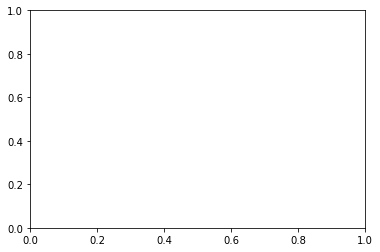

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(cv2.imread(X_train[231]))
rect = patches.Rectangle((5,38),131,159, linewidth = 2, edgecolor = 'r', facecolor='none')

ax.add_patch (rect)
plt.show()

#5	38	131	159
#173	72	265	158
#72	105	288	291

AttributeError: 'str' object has no attribute 'shape'

In [45]:
y_train[97]

array([39.424, 22.528, 44.032, 47.872])

In [115]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, f in enumerate (X_train):
    img = Image.open(f)
    img = img.resize((image_size, image_size))
    img = img.convert('RGB')
    
    X_train[i] = preprocess_input(np.array(img, dtype = np.float32))
    img.close()


In [116]:
X_train = np.array(X_train)

In [117]:
X_train.shape

(3006, 128, 128, 3)

In [119]:
len (y_train)

3006

In [131]:
with open (val_csv,'r') as f:
    y_val = np.zeros((sum(1 for line in f),4))
    X_val = []
    f.seek(0)
    data = csv.reader(f, delimiter = ',')
    for index, row in enumerate (data):
        for i, r in enumerate(row[1:7]):
            row[i+1]= int(r)
        path, image_height, image_width, x0, y0, x1, y1,_,_, = row
        path = './' + path.split('/')[-2] +'/' + path.split('/')[-1]
        
        y_val[index, 0] = x0*image_size/image_width
        y_val[index, 1] = y0*image_size/image_height
        y_val[index, 2] = (x1-x0)*image_size/image_width
        y_val[index, 3] = (y1-y0)*image_size/image_width
        
        X_val.append(path) 


In [133]:
for i, f in enumerate(X_val):
    img = Image.open(f)
    img = img.resize((image_size, image_size))
    img = img.convert('RGB')
    
    X_val[i] = preprocess_input(np.array(img, dtype = np.float32))
    img.close()
    
    


In [129]:
for i, f in enumerate(X_val):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_val[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [124]:
for i, f in enumerate(X_val):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_val[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [135]:
X_val = np.array(X_val)

In [136]:
X_val.shape

(680, 128, 128, 3)

In [137]:
y_val


array([[  0.38438438,   8.704     ,  98.4024024 , 103.3993994 ],
       [ 33.82582583,  24.064     ,  45.74174174,  38.82282282],
       [  6.99678457,  10.        ,  77.78778135,  63.79421222],
       ...,
       [ 52.48      ,  36.18133333,  28.928     ,  33.792     ],
       [ 24.832     ,   6.03141361,  49.408     ,  58.112     ],
       [ 11.776     ,  19.21921922,  67.84      ,  58.624     ]])

# Creating the model 

In [143]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape


ALPHA = 1.0

def create_model(trainable = True):
    model = MobileNet(input_shape=(image_size, image_size,3), include_top = False, alpha=ALPHA)
    
    for layer in model.layers:
        layer.trainable = trainable 
    
    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name = 'coords')(x0)
    
    x2 = Reshape ((4,))(x1)
    
    return Model(inputs = model.input, outputs=x2)


In [144]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [145]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

In [146]:
model = create_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

In [147]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

In [149]:
# Use earlystopping
import tensorflow
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[callback])

Epoch 1/10
94/94 [==============================] - 69s 715ms/step - loss: 284.2765 - IoU: 0.4592 - val_loss: 124.6525 - val_IoU: 0.5660
Epoch 2/10
94/94 [==============================] - 62s 657ms/step - loss: 90.7255 - IoU: 0.6201 - val_loss: 100.4772 - val_IoU: 0.6004
Epoch 3/10
94/94 [==============================] - 63s 676ms/step - loss: 60.8075 - IoU: 0.6786 - val_loss: 96.0317 - val_IoU: 0.6076
Epoch 4/10
94/94 [==============================] - 61s 650ms/step - loss: 44.5870 - IoU: 0.7203 - val_loss: 94.0484 - val_IoU: 0.6091
Epoch 5/10
94/94 [==============================] - 58s 623ms/step - loss: 34.2751 - IoU: 0.7497 - val_loss: 93.6124 - val_IoU: 0.6158
Epoch 6/10
94/94 [==============================] - 58s 620ms/step - loss: 26.7098 - IoU: 0.7767 - val_loss: 91.6618 - val_IoU: 0.6153


In [150]:
model.evaluate(X_val, y_val)

22/22 [==============================] - 11s 492ms/step - loss: 91.6618 - IoU: 0.6153


[91.6617660522461, 0.6153272986412048]

In [152]:
filename = './images/shiba_inu_163.jpg'
unscaled = cv2.imread(filename) # Original image for display

image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)


fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0,y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

print ("Size of original input: ", image.shape)
print("-------------------------------")
print("Size of scaled input: ", feat_scaled.shape)

Size of original input:  (128, 128, 3)
-------------------------------
Size of scaled input:  (128, 128, 3)


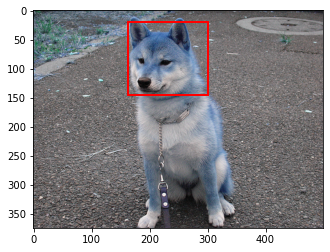

In [157]:
X_train[0].shape

(128, 128, 3)

In [160]:
test = 'images/pomeranian_83.jpg'
image = cv2.imread(test)


In [164]:
image_height, image_width,_ = image.shape
image = image.resize(image(image_size, image_size ))

TypeError: 'numpy.ndarray' object is not callable

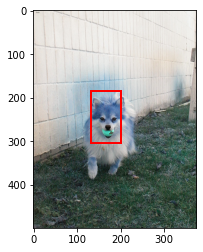

Size of original input:  (128, 128, 3)
-------------------------------
Size of scaled input:  (128, 128, 3)


In [173]:
filename = 'images/pomeranian_83.jpg'
unscaled = cv2.imread(filename) # Original image for display

image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)


fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0,y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

print ("Size of original input: ", image.shape)
print("-------------------------------")
print("Size of scaled input: ", feat_scaled.shape)

In [174]:
file = 'images/Abyssinian_143.jpg'
unscaled = cv2.imread(file)

image_height, image_width,_,=unscaled.shape
image = cv2.resize(unscaled, (image_size, image_size))

feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

x0 = int(region[0]* image_width/ image_size)
y0 = int(region[1]* image_height/ image_size)

x1 = int ((region[0]+region[2])* image_width/ image_size)
y1 = int ((region[1]+region[3])* image_height/image_size)



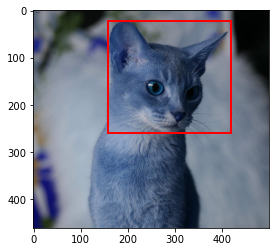

In [175]:
fig, ax = plt.subplots(1)
ax.imshow(unscaled)

rect = patches.Rectangle((x0, y0), x1 - x0,y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)


plt.show()

# SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION * SEMANTIC SEGMENTATION

In [6]:
import tensorflow as tf
import random
random.seed(0)

import warnings
warnings.filterwarnings('ignore')

import zipfile

In [9]:
with zipfile.ZipFile ('/Users/chopra/Documents/GL/semantic_img.zip','r') as myzip:
    myzip.extractall()

In [16]:
image_path = '/Users/chopra/Documents/GL/SS/images'

TRAIN_CSV = '/Users/chopra/Documents/GL/SS/train.csv'
VALIDATION_CSV = '/Users/chopra/Documents/GL/SS/validation.csv'




In [17]:
ALPHA = 1

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224



In [ ]:
with open(TRAIN_CSV, "r") as file:
  y_train = np.zeros((sum(1 for line in file), HEIGHT_CELLS, WIDTH_CELLS))
  print("y_train_shape:", y_train.shape)
  X_train_path = []
  file.seek(0)

  data = csv.reader(file, delimiter=',')

  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
        row[i+1] = int(r)

    path, image_height, image_width, x0, y0, x1, y1, _, _ = row

    path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
    path_mask = path.replace('.jpg','.png')

    mask_img = cv2.imread(path_mask)
    mask_img = (mask_img!=2)*1.0
    mask_img = cv2.resize(mask_img, (28, 28))
    mask_img = 1.0*(mask_img[:,:,0]>0.2)

    y_train[index,:,:] = np.squeeze(mask_img)
  
    X_train_path.append(path)

y_train_shape: (3006, 28, 28)
